In [1]:
import pandas as pd
from sklearn.datasets import make_blobs
from numpy import mean
from numpy import std
from numpy.random import randn
from numpy.random import seed
from numpy import cov
from scipy.stats import pearsonr 
from matplotlib import pyplot
from matplotlib.colors import ListedColormap
import sympy as sympy
import numpy as np
from scipy import *
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display, Math, Latex
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA


from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import cluster, datasets, mixture
%matplotlib inline

### (a) 4-blobs
#### (i) Clearly separated

In [28]:
# Generate sample data
np.random.seed(0)
n_samples = 1000
X, y = make_blobs(n_samples=n_samples,
                  centers=4,
                  n_features=4,
                  random_state=5)

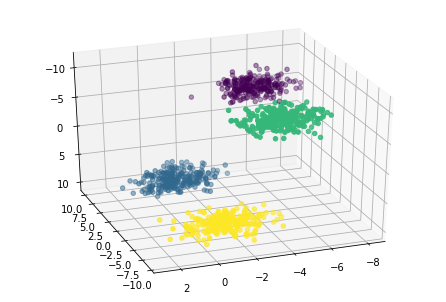

In [29]:
# Visiualize sample data in 3D view
fig = plt.figure()
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X[:,0], X[:,1], X[:,2],c=y)
plt.show()

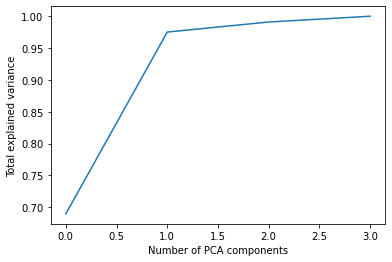

In [30]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of PCA components')
plt.ylabel('Total explained variance')
plt.show()

Elbow occurs at number of PCA components equals to 1 with explained variance of over 0.95

<ipython-input-31-155a3aee1589>:19: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  sum_EVal = sum(EVal)


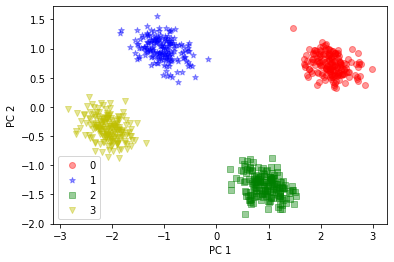

In [31]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=5)

# Standardize the features (zero mean, unit variance) 
sc = StandardScaler()

# Fit results must be used later (mu and sigma)
X_train_std = sc.fit_transform(X_train) 

# Normalize test data set with mu/sigma of training data
X_test_std = sc.transform(X_test)

# Compute covariance matrix and eigenvalues (EVal) / eigenvectors (EVec)
cov_mat = np.cov(X_train_std.T) #cov matrix from data
EVal, EVec = np.linalg.eig(cov_mat)

# Calculate (sum of) explained variances
sum_EVal = sum(EVal)
var_exp = [(i / sum_EVal) for i in sorted(EVal, reverse=True)]

# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(EVal[i]), EVec[:, i]) for i in range(len(EVal))]

# Sort the (EVal, EVec) tuples from high to low (reverse), key=EV
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
# Construct matrix w
# stacking, reshaping, adding dim of arrays
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

# Transform the entire (training) data to the PCA space, X'=X.W
X_train_pca = X_train_std.dot(w)

# Visualize the data
colors = ['r', 'b', 'g', 'y']
markers = ['o', '*', 's', 'v']
#
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], # Pick x component for label
                X_train_pca[y_train==l, 1],
                color=c, label=l, marker=m, alpha=0.4) 
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

Scatter plot of transformed data using 2 PCA components. Different classes are still clearly separated altough number of features is reduced.

In [32]:
# Set up PCA and logistic regression model
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='ovr', solver='liblinear')

# Fit and transform training data, given on PCA reduction to k(=2) principle components
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
# solves task, given 3 classes (as from y_train) 
lr.fit(X_train_pca, y_train) 

LogisticRegression(multi_class='ovr', solver='liblinear')

In [33]:
def plot_decision_regions(X, y, classifier, resolution=0.01):
    # Does not work....always....Setup marker generator and color map: FIXED!
    markers = ('s', 'v', 'o', '*') 
    colors = ('purple', 'yellow', 'g', 'r')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    # Z is the prediction of the class, given point in plane
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    # Z=f(xx1,yy1), plot classes in plane using color map but opaque
    plt.contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot data points, given labels
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=[cmap(idx)],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

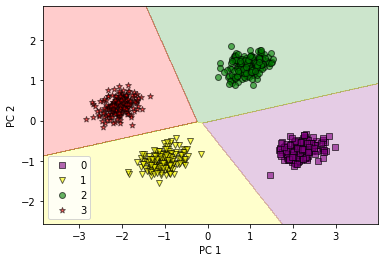

In [34]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

Decision boundaries on training data

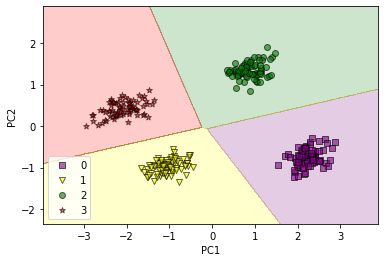

In [35]:
# plot decision regions for test set
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.show()

Decision boundaries on testing data. All datapoints are correctly classified.

### (ii)Significantly overlapped

In [5]:
# Generate sample data
np.random.seed(0)
n_samples = 1000
X, y = make_blobs(n_samples=n_samples,
                  centers=4,
                  n_features=4,
                  cluster_std=[5, 5, 5, 5], 
                  random_state=10)

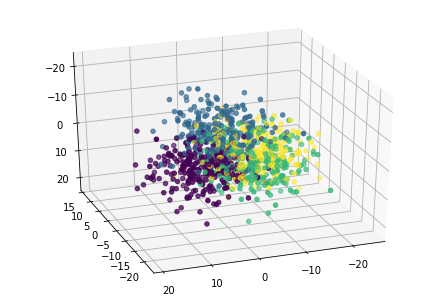

In [6]:
# Visiualize sample data in 3D view
fig = plt.figure()
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X[:,0], X[:,1], X[:,2],c=y)
plt.show()

We increased standard deviation in each blob to create more overlap.

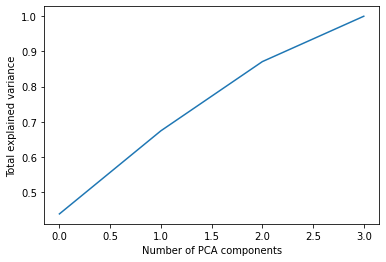

In [7]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of PCA components')
plt.ylabel('Total explained variance')
plt.show()

A turning point at number of PCA components is 2 can be spotted although not very drastic

<ipython-input-8-155a3aee1589>:19: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  sum_EVal = sum(EVal)


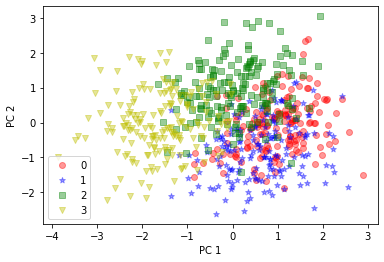

In [8]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=5)

# Standardize the features (zero mean, unit variance) 
sc = StandardScaler()

# Fit results must be used later (mu and sigma)
X_train_std = sc.fit_transform(X_train) 

# Normalize test data set with mu/sigma of training data
X_test_std = sc.transform(X_test)

# Compute covariance matrix and eigenvalues (EVal) / eigenvectors (EVec)
cov_mat = np.cov(X_train_std.T) #cov matrix from data
EVal, EVec = np.linalg.eig(cov_mat)

# Calculate (sum of) explained variances
sum_EVal = sum(EVal)
var_exp = [(i / sum_EVal) for i in sorted(EVal, reverse=True)]

# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(EVal[i]), EVec[:, i]) for i in range(len(EVal))]

# Sort the (EVal, EVec) tuples from high to low (reverse), key=EV
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
# Construct matrix w
# stacking, reshaping, adding dim of arrays
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

# Transform the entire (training) data to the PCA space, X'=X.W
X_train_pca = X_train_std.dot(w)

# Visualize the data
colors = ['r', 'b', 'g', 'y']
markers = ['o', '*', 's', 'v']
#
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], # Pick x component for label
                X_train_pca[y_train==l, 1],
                color=c, label=l, marker=m, alpha=0.4) 
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

No clear boundaries when plotted with 2 PCA components yet clusters are still identifiable

In [9]:
# Set up PCA and logistic regression model
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='ovr', solver='liblinear')

# Fit and transform training data, given on PCA reduction to k(=2) principle components
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
# solves task, given 3 classes (as from y_train) 
lr.fit(X_train_pca, y_train) 

LogisticRegression(multi_class='ovr', solver='liblinear')

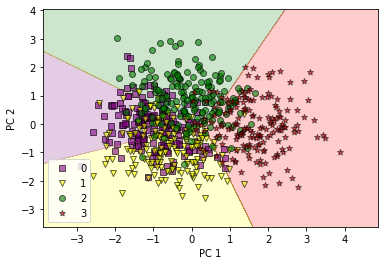

In [11]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

Decision boundaries on training data

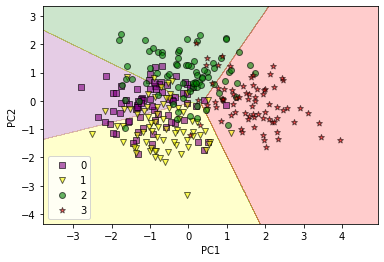

In [12]:
# plot decision regions for test set
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.show()

Decision boundaries on testing data. There is misclassification somtimes but the model does a decent job overall. Compared to the dataset where 4 blobs have no overlap, the accuracy is much lower.

### (b) 2 touching parabola

In [51]:
# Generate 2 touching parabola sample data
np.random.seed(1)
n_sample=1500
n = int(n_sample/2)
x1 = np.random.uniform(-10, 10, size=n)
x2 = np.random.uniform(-10, 10, size=n)
y1 = x1**2 + np.random.normal(0, 10, size=n)
y2 = -(x2**2 + np.random.normal(0, 10, size=n))
z1 = np.random.uniform(-10, 10, size=n)
z2 = np.random.uniform(-10, 10, size=n)

color1 = np.ones(n)
color2 = np.zeros(n)

data1 = np.column_stack((x1, y1, z1, color1))
data2 = np.column_stack((x2, y2, z2, color2))
data = np.vstack((data1, data2))

X, y = data[:,:3], data[:,3]

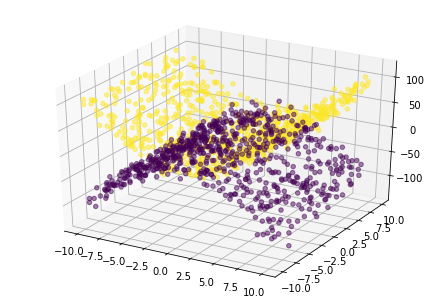

In [52]:
fig = plt.figure()
plt3d = Axes3D(fig)
plt3d.scatter(X[:,0], X[:,2], X[:,1], c=y, alpha=0.5)
plt.show()

Visualizing in 3D

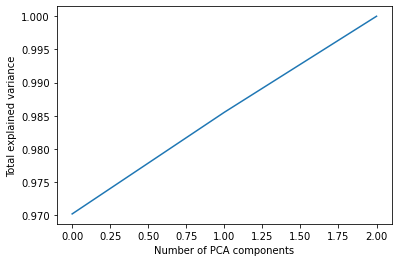

In [53]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of PCA components')
plt.ylabel('Total explained variance')
plt.show()

No elbow in this case due to the fact that data is uniformly distributed in all dimensions except for y = x**2

<ipython-input-54-072f1d030e0b>:19: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  sum_EVal = sum(EVal)


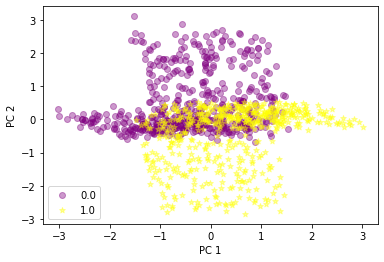

In [54]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=5)

# Standardize the features (zero mean, unit variance) 
sc = StandardScaler()

# Fit results must be used later (mu and sigma)
X_train_std = sc.fit_transform(X_train) 

# Normalize test data set with mu/sigma of training data
X_test_std = sc.transform(X_test)

# Compute covariance matrix and eigenvalues (EVal) / eigenvectors (EVec)
cov_mat = np.cov(X_train_std.T) #cov matrix from data
EVal, EVec = np.linalg.eig(cov_mat)

# Calculate (sum of) explained variances
sum_EVal = sum(EVal)
var_exp = [(i / sum_EVal) for i in sorted(EVal, reverse=True)]

# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(EVal[i]), EVec[:, i]) for i in range(len(EVal))]

# Sort the (EVal, EVec) tuples from high to low (reverse), key=EV
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
# Construct matrix w
# stacking, reshaping, adding dim of arrays
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

# Transform the entire (training) data to the PCA space, X'=X.W
X_train_pca = X_train_std.dot(w)

# Visualize the data
colors = ['purple', 'yellow']
markers = ['o', '*']
#
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], # Pick x component for label
                X_train_pca[y_train==l, 1],
                color=c, label=l, marker=m, alpha=0.4) 
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

Visualized representation of the original data containing only 2 features. Number of dimension is reduced by 1 while the parabola shape is preserved.

In [55]:
# Set up PCA and logistic regression model
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='ovr', solver='liblinear')

# Fit and transform training data, given on PCA reduction to k(=2) principle components
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
# solves task, given 3 classes (as from y_train) 
lr.fit(X_train_pca, y_train) 

LogisticRegression(multi_class='ovr', solver='liblinear')

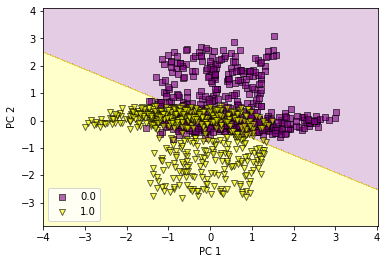

In [56]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

Decision boundary on training data

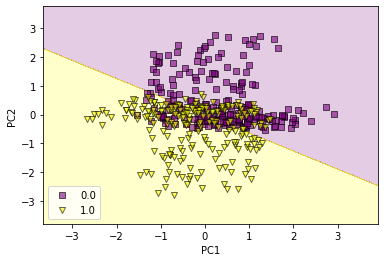

In [57]:
# plot decision regions for test set
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.show()

Decision boundary on testing data